# Variables Macro Economicas y su interdependencia

<div align="justify">Existen ciertos calificadores o métricas definidos para medir el desempeño de la macro economía de los países, estos indicadores son aceptados internacionalmente como buenos predictores y son el ‘Producto Interno Bruto’ (PIB), las tasas de interés (el ‘valor del dinero’ o el ‘costo de los créditos’), el porcentaje de la población económicamente activa sin empleo (la ‘tasa de desempleo’), la ‘inflación’ o la depreciación del poder adquisitivo de la gente y el ‘riesgo-país’ o en inglés llamado ‘bond index’ (sobre todo para economías emergentes) que mide el riesgo de invertir en un país con motivos de inestabilidad política, entre otros factores.<br>
En este trabajo quise hacer un análisis histórico de la economía mexicana en los últimos 16 años, agregando a los calificadores mencionados anteriormente, otros que creo de relevancia como la cantidad de importaciones y exportaciones en dólares, así como las inversiones extranjeras que entran a nuestro país, el tipo de cambio del peso mexicano contra el dólar estadounidense (que nos podría dar una idea de la dependencia de nuestra economía de la economía estadounidense), así como los índices de la Bolsa Mexicana de Valores y los precios del petróleo crudo puesto que nuestra economía depende en gran medida de este sector en particular.<br>
Dado que no tengo estudios en esta área tuve que hacer una investigación inicial al respecto de las métricas o calificadores utilizados para medir el desempeño de una economía y poder realizar este análisis.<br>
    Si bien entiendo a la economía comparable a un organismo vivo donde los valores de los calificadores se podrían interpretar como los signos vitales de una persona, los cuales deben mantenerse dentro de unos rangos específicos para saber si se encuentra saludable o no, mi sentido común me hace pensar que más que haber variables dependientes e independientes, todas son interdependientes entre sí y esa interdependencia es la que intentaré modelar en este proyecto.</div>
    
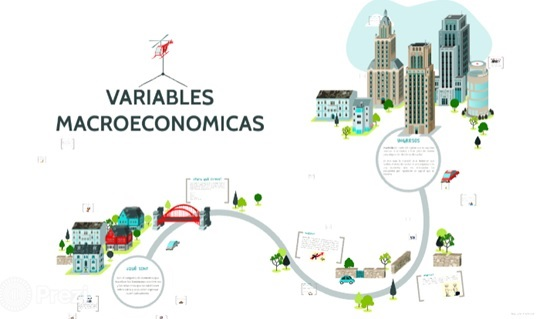
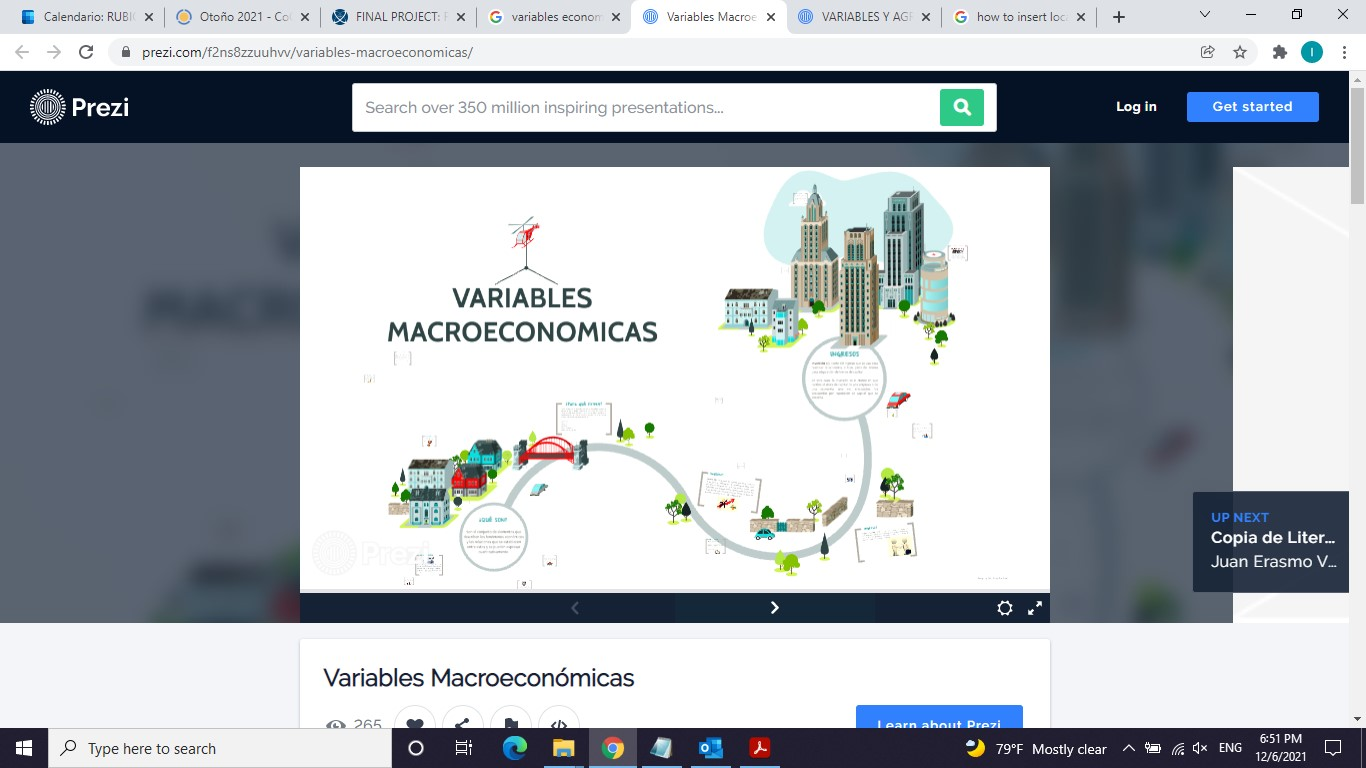

## 1. Problem description
Para este proyecto estoy considerando solamente 8 aspectos de la macro-economía que normalmente pueden ser tratados como variables aleatorias continuas de tipo cuantitativo, pero para poder modelar con una red bayesiana como aprendimos en el curso las transformaré en variables de tipo categórico donde, sin especificar cantidades o valores numéricos, se le asignarán a cada variable o nodo un estado, el cual en la mayoría de las ocasiones será binario por simplicidad (alto vs bajo). <br>
Si bien para mi trabajo de grado me gustaría explorar la posibilidad de llevar esta red bayesiana al ámbito continuo donde se le puedan asignar rangos numéricos a las variables en lugar de estados discretos, ese tipo de análisis sobrepasa los alcances del presente proyecto.<br>
Todas las relaciones de dependencia entre las variables las estoy definiendo a través de mi conocimiento empírico puesto que no cuento con estudios en economía ni consulté a ningún experto en la materia previamente a realizar este análisis. Sin embargo, al ser este un análisis simplificado de las variables como categóricas con estados discretos de alto o bajo, afectándose entre ellas únicamente de manera positiva o negativa, creo que la lógica y el sentido común son suficientes para estableces estas relaciones sin afectar de manera significativa el resultado a diferencia de si el análisis fuera más complejo.<br>
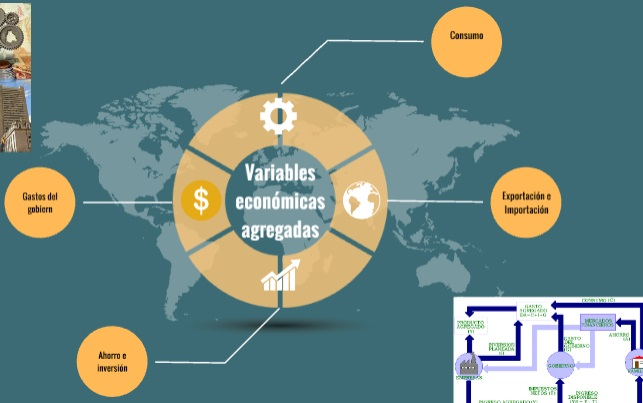

## 2. Probabilistic graphical model proposal

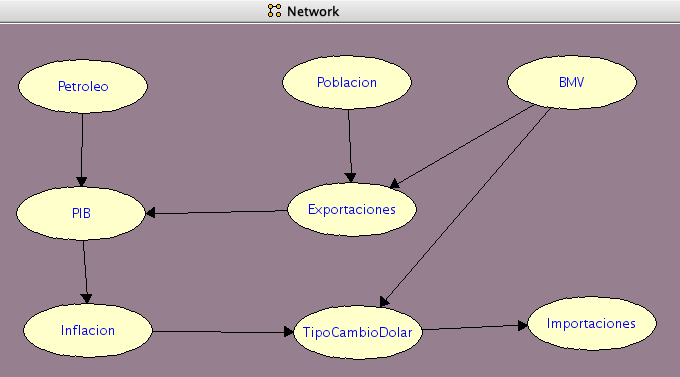

In [45]:
from pgmpy.models import BayesianModel
from pgmpy.factors.discrete import TabularCPD
import pgmpy.factors.discrete as dis

# Defining the model structure. We can define the network by just passing a list of edges.
model = BayesianModel([('Precio_Petroleo', 'PIB'),
                       ('Poblacion_Economicamente_Activa', 'Exportaciones'),
                       ('Exportaciones', 'PIB'),
                       ('Bolsa_Mexicana_Valores', 'Exportaciones'),
                       ('Bolsa_Mexicana_Valores','Tipo_Cambio_Dolar'),
                       ('PIB','Inflacion'),
                       ('Inflacion','Tipo_Cambio_Dolar'),
                       ('Tipo_Cambio_Dolar','Importaciones')])

cpd_Precio_Petroleo = TabularCPD(variable='Precio_Petroleo', variable_card=2, values=[[0.3], [0.7]])
cpd_Poblacion_Economicamente_Activa = TabularCPD(variable='Poblacion_Economicamente_Activa', variable_card=2, values=[[0.4], [0.6]])
cpd_Bolsa_Mexicana_Valores = TabularCPD(variable='Bolsa_Mexicana_Valores', variable_card=2, values=[[0.3], [0.7]])
cpd_Exportaciones = TabularCPD(variable='Exportaciones', variable_card=2, 
                    values=[[0.999, 0.9, 0.35, 0.15],
                            [0.001, 0.1, 0.65, 0.85]],
                   evidence=['Poblacion_Economicamente_Activa', 'Bolsa_Mexicana_Valores'],
                   evidence_card=[2, 2])
cpd_PIB = TabularCPD(variable='PIB', variable_card=2, 
                    values=[[0.85, 0.25, 0.9, 0.001],
                            [0.15, 0.75, 0.1, 0.999]],
                   evidence=['Precio_Petroleo', 'Exportaciones'],
                   evidence_card=[2, 2])
cpd_Inflacion = TabularCPD(variable='Inflacion', variable_card=2, 
                    values=[[0.29, 0.78],
                            [0.71, 0.22]],
                   evidence=['PIB'],
                   evidence_card=[2])
cpd_Tipo_Cambio_Dolar = TabularCPD(variable='Tipo_Cambio_Dolar', variable_card=2, 
                    values=[[0.6, 0.95, 0.001, 0.2],
                            [0.4, 0.05, 0.999, 0.8]],
                   evidence=['Bolsa_Mexicana_Valores', 'Inflacion'],
                   evidence_card=[2, 2])
cpd_Importaciones = TabularCPD(variable='Importaciones', variable_card=2, 
                    values=[[0.11, 0.69],
                            [0.89, 0.31]],
                   evidence=['Tipo_Cambio_Dolar'],
                   evidence_card=[2])
model.add_cpds(cpd_Precio_Petroleo,cpd_Poblacion_Economicamente_Activa,cpd_Bolsa_Mexicana_Valores,cpd_Exportaciones,cpd_PIB,cpd_Inflacion,cpd_Tipo_Cambio_Dolar,cpd_Importaciones)
model.check_model()

True

## 3. Model evaluation

Para evaluar el modelo he diseñado una métrica en base a si las probabilidades suben o bajan de acuerdo a los diferentes estados de una variable base reflejado en una variable objetivo, a como lo codificaría la intuición, por ejemplo, si la relación entre Inflación y Tipo de Cambio es positiva (a mayor inflación se requieren más pesos para comprar 1 dólar), se esperaría que la probabilidad aumente conforme los estados de la inflación aumentan. <br>
En base a la intuición o a la lógica, conforme se definieron las relaciones de dependencia entre las variables, se define asímismo una matriz de n x n donde n es la cantidad de variables analizadas (en este caso 8), y si su relación es positiva se codifica con un 1 en la celda de la intersección de los índices de ambas variables. Si la relación es negativa, se codifica como un -1 y si no existe relación (es decir, no hay arco entre los nodos), se codifica con un 0.
Después definimos una función donde dependiendo si la probabilidad aumenta conforme aumentan los estados de la variable base, se codifica con un 1 y si la probabilidad disminuye conforme aumentan los estados de la variable base, se codifica con un -1. Finalmente se multiplica ese valor por el componente i,j de la matriz definida anteriormente. <br>
Lo que se espera es que si el modelo se comporta como a la intuición, el resultado de estas multiplicaciones debe ser positivo (signos iguales multiplicados dan positivo) y si existe discrepancia entonces el resultado debería ser negativo (signos diferentes multiplicados dan negativo). De esta manera se obtiene la métrica para evaluar al modelo, si el resultado es mayor que 0 el modelo funciona; si es menor que 0, no funciona.

In [17]:
def compute_joint_distribution(cpds):
    factors = [cpd.to_factor() for cpd in cpds]
    joint = factors[0].identity_factor()
    for f in factors:
        joint = joint * f
    return joint

def compute_marginal(cpds, variables, evidence):
    #Paso 0 calcular la distribucion conjunta
    joint = compute_joint_distribution(cpds)
    #Paso 1 obtener la lista de todas las variables involucradas
    todasVariables = joint.scope()
    #Paso 2 obtener las variables a marginalizar
    variablesMarginalizar = (set(todasVariables) - set(variables)) - set([e[0] for e in evidence])
    #Paso 3 marginalizar
    marginal = joint.marginalize(variables = variablesMarginalizar, inplace = False)
    #Paso 4 reducir de acuerdo a la evidencia
    marginal_reducida = marginal.reduce(values = evidence, inplace = False)
    #Paso 5 normalizar
    marginal_reducida.values = marginal_reducida.values / marginal_reducida.values.sum()
    return marginal_reducida

In [18]:
import numpy as np
variables_nm = ['Precio_Petroleo',
                'Inflacion',
                'PIB',
                'Tipo_Cambio_Dolar',
                'Exportaciones',
                'Importaciones',
                'Poblacion_Economicamente_Activa',
                'Bolsa_Mexicana_Valores']
matriz = np.array([[0,0,1,0,0,0,0,0],
                   [0,0,0,1,0,0,0,0],
                   [0,-1,0,0,0,0,0,0],
                   [0,0,0,0,0,-1,0,0],
                   [0,0,1,0,0,0,0,0],
                   [0,0,0,0,0,0,0,0],
                   [0,0,0,0,1,0,0,0],
                   [0,0,0,-1,1,0,0,0]])

In [46]:
print(compute_marginal(model.get_cpds(),['Inflacion'],[('Precio_Petroleo',0)]))
print(compute_marginal(model.get_cpds(),['Inflacion'],[('Precio_Petroleo',1)]))

+--------------+------------------+
| Inflacion    |   phi(Inflacion) |
+==============+==================+
| Inflacion(0) |           0.4411 |
+--------------+------------------+
| Inflacion(1) |           0.5589 |
+--------------+------------------+
+--------------+------------------+
| Inflacion    |   phi(Inflacion) |
+==============+==================+
| Inflacion(0) |           0.4553 |
+--------------+------------------+
| Inflacion(1) |           0.5447 |
+--------------+------------------+


In [47]:
print(compute_marginal(model.get_cpds(),['Importaciones'],[('Inflacion',0)]))
print(compute_marginal(model.get_cpds(),['Importaciones'],[('Inflacion',1)]))

+------------------+----------------------+
| Importaciones    |   phi(Importaciones) |
+==================+======================+
| Importaciones(0) |               0.4353 |
+------------------+----------------------+
| Importaciones(1) |               0.5647 |
+------------------+----------------------+
+------------------+----------------------+
| Importaciones    |   phi(Importaciones) |
+==================+======================+
| Importaciones(0) |               0.2807 |
+------------------+----------------------+
| Importaciones(1) |               0.7193 |
+------------------+----------------------+
